# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-3/breakpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 断点（Breakpoints）

## 回顾

在 `人机协作（human-in-the-loop）` 场景中，我们经常希望在图执行过程中查看输出结果。

我们已经在流式处理中为此奠定了基础。

## 学习目标

现在，让我们讨论 `人机协作` 的动机：

(1) **审批（Approval）** - 我们可以中断智能体，向用户展示状态，并允许用户接受某个操作

(2) **调试（Debugging）** - 我们可以回退图执行来重现或避免问题

(3) **编辑（Editing）** - 您可以修改状态

LangGraph 提供了多种方式来获取或更新智能体状态，以支持各种 `人机协作` 工作流。

首先，我们将介绍[断点](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/#simple-usage)，它提供了一种在特定步骤停止图执行的简单方法。

我们将展示这如何实现用户 `审批` 功能。

In [1]:
# 安装必要的依赖包
# 使用 %%capture 隐藏安装过程的输出信息
%%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32 langchain_core==0.3.75 langgraph_sdk==0.2.6 langgraph-prebuilt==0.6.4

In [2]:
# 导入必要的模块
import os, getpass

def _set_env(var: str):
    """
    设置环境变量的辅助函数
    如果环境变量不存在，则提示用户输入
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


## 用于人工审批的断点

让我们重新考虑在模块1中使用的简单智能体。

假设我们关心工具的使用：我们希望审批智能体使用其任何工具。

我们只需要在编译图时使用 `interrupt_before=["tools"]`，其中 `tools` 是我们的工具节点。

这意味着执行将在 `tools` 节点之前被中断，该节点负责执行工具调用。

In [3]:
# 导入 OpenAI 聊天模型
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """
    乘法函数：计算两个整数的乘积

    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    加法函数：计算两个整数的和

    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    除法函数：计算两个整数的商

    Args:
        a: 被除数
        b: 除数
    """
    return a / b

# 定义工具列表，这些函数将被智能体作为工具使用
tools = [add, multiply, divide]

# 初始化 OpenAI 聊天模型
llm = ChatOpenAI(model="gpt-4o")

# 将工具绑定到语言模型，使模型能够调用这些工具
llm_with_tools = llm.bind_tools(tools)

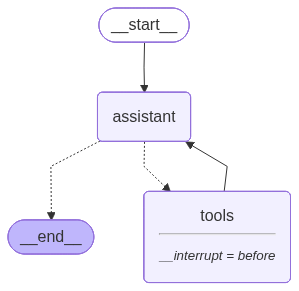

In [4]:
# 导入必要的模块
from IPython.display import Image, display

# 导入 LangGraph 相关模块
from langgraph.checkpoint.memory import MemorySaver  # 内存检查点保存器
from langgraph.graph import MessagesState  # 消息状态类型
from langgraph.graph import START, StateGraph  # 图构建相关
from langgraph.prebuilt import tools_condition, ToolNode  # 预构建的工具节点和条件

# 导入 LangChain 消息类型
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# 定义系统消息，指导智能体的行为
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 定义智能体节点函数
def assistant(state: MessagesState):
    """
    智能体节点：处理用户输入并决定是否需要调用工具

    Args:
        state: 包含消息历史的状态对象

    Returns:
        包含新消息的字典
    """
    # 将系统消息和用户消息一起发送给语言模型
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# 创建状态图构建器
builder = StateGraph(MessagesState)

# 定义节点：这些节点执行具体的工作
builder.add_node("assistant", assistant)  # 智能体节点
builder.add_node("tools", ToolNode(tools))  # 工具执行节点

# 定义边：这些边决定控制流程
builder.add_edge(START, "assistant")  # 从开始到智能体

# 添加条件边：根据智能体的输出决定下一步
builder.add_conditional_edges(
    "assistant",
    # 如果智能体的最新消息是工具调用 -> tools_condition 路由到 tools 节点
    # 如果智能体的最新消息不是工具调用 -> tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")  # 从工具节点回到智能体

# 创建内存检查点保存器
memory = MemorySaver()

# 编译图，设置断点在 "tools" 节点之前
# interrupt_before=["tools"] 表示在执行 tools 节点之前会中断
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# 显示图的可视化结构
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# 定义初始输入：用户要求计算 2 乘以 3
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# 创建线程配置，用于跟踪对话状态
thread = {"configurable": {"thread_id": "1"}}

# 运行图直到第一个中断点
# 由于设置了 interrupt_before=["tools"]，执行会在 tools 节点之前停止
for event in graph.stream(initial_input, thread, stream_mode="values"):
    # 打印最新的消息内容
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_paOosxIg3dOQUybOGHcTUkOd)
 Call ID: call_paOosxIg3dOQUybOGHcTUkOd
  Args:
    a: 2
    b: 3


我们可以获取状态并查看下一个要调用的节点。

这是查看图是否已被中断的好方法。

In [6]:
# 获取当前图的状态
state = graph.get_state(thread)

# 查看下一个要执行的节点
# 这应该显示 ('tools',) 表示下一个要执行的是 tools 节点
state.next

('tools',)

现在，我们将介绍一个巧妙的技巧。

当我们使用 `None` 调用图时，它将从最后一个状态检查点继续执行！

![断点示意图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

为了清晰起见，LangGraph 将重新发出当前状态，其中包含带有工具调用的 `AIMessage`。

然后它将继续执行图中的后续步骤，从工具节点开始。

我们看到工具节点使用这个工具调用运行，然后结果被传递回聊天模型以获得最终答案。

In [7]:
# 使用 None 作为输入继续执行图
# 这将从上次中断的地方继续执行
for event in graph.stream(None, thread, stream_mode="values"):
    # 打印最新的消息内容
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_paOosxIg3dOQUybOGHcTUkOd)
 Call ID: call_paOosxIg3dOQUybOGHcTUkOd
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


现在，让我们将这些功能与一个接受用户输入的特定用户审批步骤结合起来。

In [8]:
# 定义初始输入：用户要求计算 2 乘以 3
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# 创建新的线程配置
thread = {"configurable": {"thread_id": "2"}}

# 运行图直到第一个中断点
print("=== 执行到断点 ===")
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# 获取用户反馈
print("\n=== 等待用户审批 ===")
user_approval = input("您是否要调用工具？(yes/no): ")

# 检查审批结果
if user_approval.lower() == "yes":
    print("\n=== 用户批准，继续执行 ===")
    # 如果批准，继续执行图
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

else:
    print("操作已被用户取消。")

=== 执行到断点 ===
================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_RPcjBwTaDzu53pWY8Jl00S1B)
 Call ID: call_RPcjBwTaDzu53pWY8Jl00S1B
  Args:
    a: 2
    b: 3

=== 等待用户审批 ===
您是否要调用工具？(yes/no): no
操作已被用户取消。


### 使用 LangGraph API 的断点

**⚠️ 免责声明**

自这些视频录制以来，我们已经更新了 Studio，使其可以在本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是使用视频中显示的桌面应用程序）。请参阅[本地开发服务器](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)的文档和[运行开发服务器](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)的文档。要启动本地开发服务器，请在此模块的 `/studio` 目录中的终端运行以下命令：

```
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

打开浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

LangGraph API [支持断点](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_breakpoint/#sdk-initialization)。

In [9]:
# 检查是否在 Google Colab 环境中运行
# 如果是，则抛出异常，因为 LangGraph Studio 目前不支持 Google Colab
if 'google.colab' in str(get_ipython()):
    raise Exception("不幸的是，LangGraph Studio 目前不支持 Google Colab")

Exception: 不幸的是，LangGraph Studio 目前不支持 Google Colab

In [ ]:
# 这是本地开发服务器的 URL
from langgraph_sdk import get_client

# 创建 LangGraph SDK 客户端，连接到本地开发服务器
client = get_client(url="http://127.0.0.1:2024")

如上所示，我们可以在编译在 Studio 中运行的图时添加 `interrupt_before=["node"]`。

但是，使用 API 时，您也可以直接将 `interrupt_before` 传递给 stream 方法。

In [ ]:
# 定义初始输入
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# 创建新的线程
thread = await client.threads.create()

# 使用 API 流式运行，在 tools 节点之前中断
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],  # 在 tools 节点之前中断
):
    print(f"接收到新事件类型: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

现在，我们可以像之前一样通过传递 `thread_id` 和 `None` 作为输入从断点继续执行！

In [ ]:
# 从断点继续执行
# 使用 None 作为输入，从上次中断的地方继续
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,  # 使用 None 从断点继续
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"接收到新事件类型: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)